# Homework 3
<span style="font-size:1.25em"> Emre Kara  </span>  
<span style="font-size:1em"> 01.02.2021 </span>

## Data Load and Preparation

In [1]:
#Libraries
require(data.table, quietly = TRUE)
require(glue, quietly = TRUE)
require(ggplot2, quietly = TRUE)
require(scatterplot3d, quietly = TRUE)
require(gridExtra, quietly = TRUE)
require(tidyr, quietly = TRUE)
require(tseries, quietly = TRUE)

Warning message:
"package 'data.table' was built under R version 3.6.3"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


In [2]:
#Dataload
path <- "Data/RealTimeConsumption-01012016-01122020.csv"
df <- fread(path)

In [3]:
head(df);sapply(df, typeof) #Checking up on data

Date,Hour,Consumption (MWh)
01.01.2016,00:00,"26,277.24"
01.01.2016,01:00,"24,991.82"
01.01.2016,02:00,"23,532.61"
01.01.2016,03:00,"22,464.78"
01.01.2016,04:00,"22,002.91"
01.01.2016,05:00,"21,957.08"


Date              Hour Consumption (MWh) 
      "character"       "character"       "character"

In [4]:
#Transforming Columns
colnames(df)[3] <- "Consumption" #Renaming Column
df[,Date := as.POSIXct(paste(Date,Hour,sep=" "), format = "%d.%m.%Y %H:%M")] #Converting to datetime
df[,Hour := as.integer(hour(Date))] #Converting column "Hour" to integer 
df[,Consumption := as.numeric( sub(",","",Consumption))] #Replacing ',' with NA
names(df)[1] = "Datetime" #Renaming Column
head(df,10);sapply(df, typeof)

Datetime,Hour,Consumption
2016-01-01 00:00:00,0,26277.24
2016-01-01 01:00:00,1,24991.82
2016-01-01 02:00:00,2,23532.61
2016-01-01 03:00:00,3,22464.78
2016-01-01 04:00:00,4,22002.91
2016-01-01 05:00:00,5,21957.08
2016-01-01 06:00:00,6,22203.54
2016-01-01 07:00:00,7,21844.16
2016-01-01 08:00:00,8,23094.73
2016-01-01 09:00:00,9,25202.27


Datetime        Hour Consumption 
   "double"   "integer"    "double"

## Logical Check

In [5]:
tdiffs <- df$Datetime[2:length(df$Datetime)] - df$Datetime[1:length(df$Datetime)-1]
table(tdiffs)
df[Consumption < mean(Consumption) - 3*sd(Consumption),]

tdiffs
    0  3600 
    1 43126 

Datetime,Hour,Consumption
2016-03-27 02:00:00,2,0.00
2020-04-12 08:00:00,8,17387.69
2020-04-12 09:00:00,9,17236.67
2020-04-12 10:00:00,10,17571.95
2020-05-23 08:00:00,8,17352.54
2020-05-24 06:00:00,6,17063.70
2020-05-24 07:00:00,7,16654.68
2020-05-24 08:00:00,8,16556.03
2020-05-24 09:00:00,9,16894.48
2020-05-24 10:00:00,10,17197.38


In [6]:
#Showing Duplicate and Missing Value
idx = which((tdiffs == 0) %in% TRUE)
df[(idx-2):(idx+2)]

Datetime,Hour,Consumption
2016-03-27 01:00:00,1,25949.63
2016-03-27 02:00:00,2,0.00
2016-03-27 04:00:00,4,24776.94
2016-03-27 04:00:00,4,24776.94
2016-03-27 05:00:00,5,24098.97


In [7]:
#Handling Duplicate Record
df[idx,"Hour"] <- 3
df[(idx-2):(idx+2)]

Datetime,Hour,Consumption
2016-03-27 01:00:00,1,25949.63
2016-03-27 02:00:00,2,0.00
2016-03-27 04:00:00,3,24776.94
2016-03-27 04:00:00,4,24776.94
2016-03-27 05:00:00,5,24098.97


In [8]:
#Showing 0 Value
idx = which( (df$Datetime== as.POSIXct("2016-03-27 02:00:00")) %in% TRUE )
df[(idx-2):(idx+2)]

Datetime,Hour,Consumption
2016-03-27 00:00:00,0,27424.42
2016-03-27 01:00:00,1,25949.63
2016-03-27 02:00:00,2,0.00
2016-03-27 04:00:00,3,24776.94
2016-03-27 04:00:00,4,24776.94


In [9]:
#Replacing with the Average of t-1 and t+1
df[idx,Consumption := (df[idx-1,Consumption] + df[idx+1,Consumption] ) / 2 ]
df[(idx-1):(idx+1)]

Datetime,Hour,Consumption
2016-03-27 01:00:00,1,25949.63
2016-03-27 02:00:00,2,25363.28
2016-03-27 04:00:00,3,24776.94


# Task a

## Train-Test Split Function

In [10]:
dtsplit <- function(data) {
    res <- list()
    res[[1]] <- data[Datetime < as.POSIXct("2020-11-01 00:00:00")]
    res[[2]] <- data[Datetime >= as.POSIXct("2020-11-01 00:00:00")]
    return(res)
}

## Creating Variables

In [11]:
idx <- seq(1,nrow(df) )
idx48 <- idx - 48
idx168 <- idx - 168
head(idx);head(idx48);head(idx168)

[1] 1 2 3 4 5 6

[1] -47 -46 -45 -44 -43 -42

[1] -167 -166 -165 -164 -163 -162

In [12]:
idx48[which(idx48 <1)] <- NA; head(idx48)
idx168[which(idx168 <1)] <- NA; head(idx168)

[1] NA NA NA NA NA NA

[1] NA NA NA NA NA NA

In [13]:
df[,Lag_48 := Consumption[idx48]]
df[,Lag_168 := Consumption[idx168]]

In [14]:
df[500,"Lag_48"];df[500,"Lag_168"];df[452,"Consumption"];df[332,"Consumption"]

Lag_48
35893.88


Lag_168
34914.82


Consumption
35893.88


Consumption
34914.82


In [15]:
pAtest <- dtsplit(df)[[2]];head(pAtest)

Datetime,Hour,Consumption,Lag_48,Lag_168
2020-11-01 00:00:00,0,28701.62,29066.51,29481.33
2020-11-01 01:00:00,1,27254.15,27838.89,28002.28
2020-11-01 02:00:00,2,26078.57,26940.11,27115.39
2020-11-01 03:00:00,3,25449.47,26260.80,26415.11
2020-11-01 04:00:00,4,25324.01,26097.96,26075.07
2020-11-01 05:00:00,5,25175.11,26319.40,26196.39


In [16]:
pAtest[,MAPE48 := 100*abs(Lag_48/Consumption-1)]
pAtest[,MAPE168 := 100*abs(Lag_168/Consumption-1)]
head(pAtest)

Datetime,Hour,Consumption,Lag_48,Lag_168,MAPE48,MAPE168
2020-11-01 00:00:00,0,28701.62,29066.51,29481.33,1.271322,2.716606
2020-11-01 01:00:00,1,27254.15,27838.89,28002.28,2.145508,2.745013
2020-11-01 02:00:00,2,26078.57,26940.11,27115.39,3.303632,3.975755
2020-11-01 03:00:00,3,25449.47,26260.80,26415.11,3.188004,3.794342
2020-11-01 04:00:00,4,25324.01,26097.96,26075.07,3.056191,2.965802
2020-11-01 05:00:00,5,25175.11,26319.40,26196.39,4.545323,4.056705


In [17]:
summary(pAtest[,c("MAPE48","MAPE168")])

     MAPE48            MAPE168         
 Min.   : 0.00955   Min.   : 0.008521  
 1st Qu.: 1.64348   1st Qu.: 1.335853  
 Median : 5.72972   Median : 2.514032  
 Mean   : 8.06031   Mean   : 3.449188  
 3rd Qu.:10.10699   3rd Qu.: 4.548818  
 Max.   :43.77075   Max.   :19.565225  

**MAPE48**  
The difference between mean and median values should be noted here. This situation indicates that the distribution is right-skewed and the mean value is affected by high outlier values. Also, 3rd quartile is around **10%** and the maximum value is roughly **44%** which is an extreme error percentage. These values show that the practical use of this estimator can be quite problematic.

**MAPE168**  
Median and mean values are closer which indicates a distribution closer to the normal one, but it is right-skewed again anyway. 3rd quartile value is roughly **5%** and this means one quarter of the estimations yield more than **5%** error and this is not preferrable in practical use either. However, all statistics belonging to the Lag168 estimation came out to be better than those of Lag48.

# Task b

In [18]:
pBtrain <- dtsplit(df)[[1]]
mb1 <- lm(Consumption~Lag_48+Lag_168,pBtrain,na.action = na.exclude )

In [19]:
summary(mb1)


Call:
lm(formula = Consumption ~ Lag_48 + Lag_168, data = pBtrain, 
    na.action = na.exclude)

Residuals:
     Min       1Q   Median       3Q      Max 
-17126.4   -984.1     -0.3   1016.1  16105.8 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.564e+03  8.340e+01   18.75   <2e-16 ***
Lag_48      3.083e-01  3.093e-03   99.69   <2e-16 ***
Lag_168     6.439e-01  3.090e-03  208.37   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2387 on 42213 degrees of freedom
  (168 observations deleted due to missingness)
Multiple R-squared:  0.7759,	Adjusted R-squared:  0.7759 
F-statistic: 7.308e+04 on 2 and 42213 DF,  p-value: < 2.2e-16


In [20]:
pb1 <- predict.lm(mb1,pAtest)

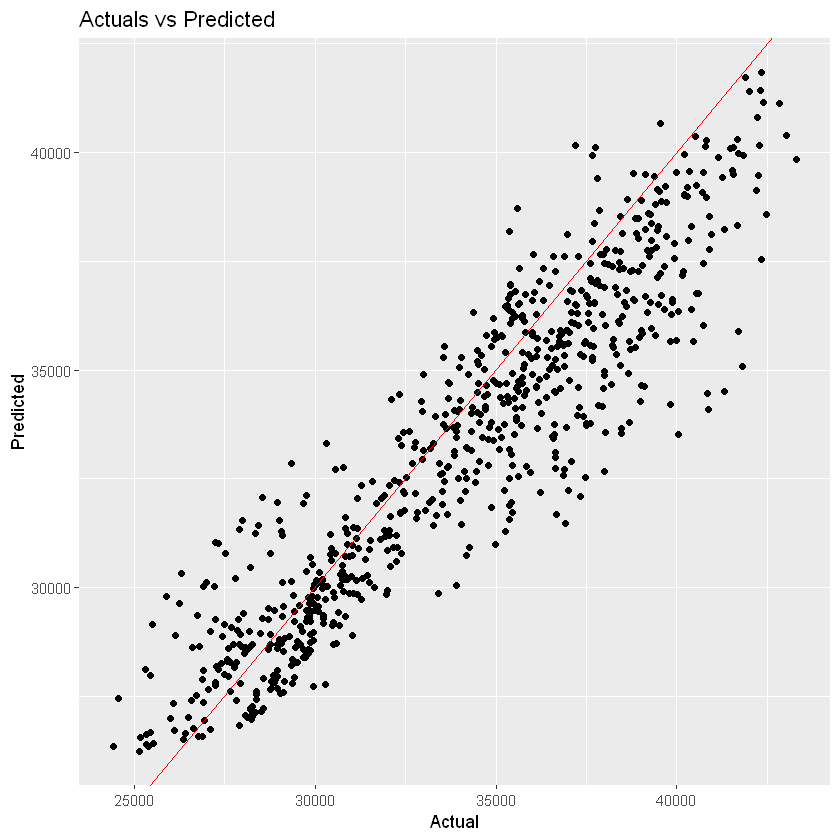

In [21]:
qplot(x = pAtest$Consumption, y= pb1) + geom_abline(intercept=0,slope=1,col=2) +
ggtitle("Actuals vs Predicted",) + xlab("Actual") + ylab("Predicted")

In [22]:
MAPEb = 100*abs(pb1/pAtest$Consumption-1)

In [23]:
summary(cbind(pAtest[,c("MAPE48","MAPE168")],MAPEb))

     MAPE48            MAPE168              MAPEb          
 Min.   : 0.00955   Min.   : 0.008521   Min.   : 0.000671  
 1st Qu.: 1.64348   1st Qu.: 1.335853   1st Qu.: 1.824296  
 Median : 5.72972   Median : 2.514032   Median : 3.310063  
 Mean   : 8.06031   Mean   : 3.449188   Mean   : 4.228027  
 3rd Qu.:10.10699   3rd Qu.: 4.548818   3rd Qu.: 5.706493  
 Max.   :43.77075   Max.   :19.565225   Max.   :16.605386  

The approach in Part b came out to be more succesful than lag48 approach looking at mean, median and maximum statistics but it is not easy to say the same while comparing to lag168. All statistics of Lag168 are better than those of part b approach except maximum and minimum values. This is due to linear regression being more robust against outliers compared to naïve approaches. Yet, Part b approach still cannot be evaluated better against Lag168 approach.

# Part c

In [24]:
mc1 <- list()
pc1 <- list()
MAPEc <- list()
for (h in unique(pBtrain$Hour)){
    datatr = pBtrain[Hour==h]
    datatest = pAtest[Hour==h]
    mc1[[h+1]] <- lm(Consumption ~ Lag_48 + Lag_168, datatr, na.action = na.omit )
    pc1[[h+1]] <- predict.lm(mc1[[h+1]], datatest)
    MAPEc[[h+1]] = 100*abs(pc1[[h+1]]/datatest$Consumption-1)
}

In [25]:
MAPEc <- data.frame(MAPEc)
colnames(MAPEc) <- paste("MAPE_H",unique(pBtrain$Hour),sep="")

## Performances of All 24 Models

In [26]:
summary(MAPEc)

    MAPE_H0          MAPE_H1          MAPE_H2          MAPE_H3      
 Min.   :0.9125   Min.   :0.1607   Min.   :0.2742   Min.   :0.2059  
 1st Qu.:1.8975   1st Qu.:2.0258   1st Qu.:2.1526   1st Qu.:1.9412  
 Median :3.1388   Median :3.0191   Median :3.5127   Median :2.6456  
 Mean   :3.2630   Mean   :3.2831   Mean   :3.4187   Mean   :3.2027  
 3rd Qu.:4.6084   3rd Qu.:4.5855   3rd Qu.:4.5463   3rd Qu.:4.3030  
 Max.   :6.7730   Max.   :7.4922   Max.   :6.6630   Max.   :6.5773  
    MAPE_H4           MAPE_H5          MAPE_H6          MAPE_H7      
 Min.   :0.07224   Min.   :0.2728   Min.   :0.1483   Min.   :0.3513  
 1st Qu.:1.95131   1st Qu.:1.9876   1st Qu.:1.2048   1st Qu.:1.8397  
 Median :3.14458   Median :2.8513   Median :2.8687   Median :3.5869  
 Mean   :3.18302   Mean   :3.1875   Mean   :3.1481   Mean   :3.7761  
 3rd Qu.:4.16730   3rd Qu.:4.6307   3rd Qu.:5.1662   3rd Qu.:5.0019  
 Max.   :6.42261   Max.   :6.3263   Max.   :6.7613   Max.   :9.2660  
    MAPE_H8            MAPE

From **H0** to **H7**, mean and median percentage errors are around **3** which are around best metrics so far. However, from **H8** to **H17**, mean and median values disperse between **4** and **6** and these values seem slightly worse than previous models. From the performance difference between **H8-H17** interval and other hours, it can be deduced that electricity consumption varies more during daytime while during nights the consumption follows a more stable pattern. Looking at mean and median values of **H18-H23** interval, which are around **3** like mean and median values of morning hours, this hypothesis can be seen more probable.  

## Comparing Overall Model with Previous Models

In [27]:
MAPEcAll <- reshape2::melt(MAPEc)["value"]
colnames(MAPEcAll)[1] <- "MAPEcAll" 

No id variables; using all as measure variables


In [28]:
summary(cbind(pAtest[,c("MAPE48","MAPE168")],MAPEb,MAPEcAll))

     MAPE48            MAPE168              MAPEb              MAPEcAll       
 Min.   : 0.00955   Min.   : 0.008521   Min.   : 0.000671   Min.   : 0.06864  
 1st Qu.: 1.64348   1st Qu.: 1.335853   1st Qu.: 1.824296   1st Qu.: 2.17941  
 Median : 5.72972   Median : 2.514032   Median : 3.310063   Median : 3.72969  
 Mean   : 8.06031   Mean   : 3.449188   Mean   : 4.228027   Mean   : 4.35771  
 3rd Qu.:10.10699   3rd Qu.: 4.548818   3rd Qu.: 5.706493   3rd Qu.: 5.91587  
 Max.   :43.77075   Max.   :19.565225   Max.   :16.605386   Max.   :16.57037  

From the summary statistics, **Part c** approach has very similar performance to that of **Part b**. All metrics have very close values but mean and median values of **part c** are slightly higher than those of **Part b**.

# Part d

In [29]:
#Adding Dates
dfD <- copy(df)
dfD[, Lag_48:=NULL]; dfD[,Lag_168:=NULL] #Deleting columns
dfD[, Date:=as.Date(Datetime,tz = Sys.timezone())]
head(dfD)

Datetime,Hour,Consumption,Date
2016-01-01 00:00:00,0,26277.24,2016-01-01
2016-01-01 01:00:00,1,24991.82,2016-01-01
2016-01-01 02:00:00,2,23532.61,2016-01-01
2016-01-01 03:00:00,3,22464.78,2016-01-01
2016-01-01 04:00:00,4,22002.91,2016-01-01
2016-01-01 05:00:00,5,21957.08,2016-01-01


## Wide Format

In [30]:
dfD <- dcast(data = dfD, value.var = names(dfD)[3],formula =  Date ~ Hour)
head(dfD)

Date,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
2016-01-01,26277.24,24991.82,23532.61,22464.78,22002.91,21957.08,22203.54,21844.16,23094.73,...,29548.32,29390.89,30734.97,32048.02,31438.11,30728.47,30166.14,29461.28,29242.83,28069.09
2016-01-02,26224.60,24708.58,23771.58,22921.29,22870.89,23325.63,23604.98,24022.70,26930.48,...,32796.18,32594.55,33358.47,34387.95,33591.26,32648.83,31897.73,31049.20,30906.43,29621.09
2016-01-03,27613.96,25779.28,24566.31,23878.42,23511.38,23672.32,23827.08,23405.11,24638.72,...,31056.47,30979.53,32297.46,33462.96,33151.03,32450.21,32093.93,31315.16,31014.19,29462.06
2016-01-04,27103.09,25439.84,24395.07,23961.03,23860.63,24418.47,25708.59,27455.39,32982.07,...,39661.98,39211.00,39760.12,39633.29,37621.41,35954.18,35114.12,34066.40,33686.83,31733.54
2016-01-05,29244.38,27637.23,26335.78,25870.23,25975.07,26318.48,27109.29,28570.22,33106.00,...,38086.11,37834.89,38599.34,38669.63,36954.78,35306.11,34301.59,33400.82,33359.37,31629.97
2016-01-06,29189.27,27614.02,26578.97,25719.19,25864.63,25918.59,27091.94,28533.05,33203.34,...,36847.22,36433.88,37581.09,37304.52,35832.00,34499.94,33670.00,32931.12,32913.06,31450.65


In [31]:
tdiffs <- dfD$Date[2:length(df$Date)] - dfD$Date[1:length(df$Date)-1] #All dates are available
table(tdiffs)

tdiffs
   1 
1796 

## Creating Variables

In [32]:
idx <- seq(1,nrow(dfD))
idx2 <- idx-2
idx2[which(idx2 < 1)] <- NA

for (i in seq(0,23)){
    col <- paste("H",i,sep="")
    colnames(dfD)[i+2] <- col
    newcol <- paste("LagD2H",i,sep = "")
    dfD[,(newcol) :=      dfD[idx2, col,with = FALSE]  ]
    
}

In [33]:
idx7 <- idx-7
idx7[which(idx7 < 1)] <- NA

for (i in seq(0,23)){
    col <- paste("H",i,sep="")
    colnames(dfD)[i+2] <- col
    newcol <- paste("LagD7H",i,sep = "")
    dfD[,(newcol) :=      dfD[idx7, col,with = FALSE]  ]
    
}
tail(dfD)

Date,H0,H1,H2,H3,H4,H5,H6,H7,H8,...,LagD7H14,LagD7H15,LagD7H16,LagD7H17,LagD7H18,LagD7H19,LagD7H20,LagD7H21,LagD7H22,LagD7H23
2020-11-26,33902.71,32459.36,31023.35,30190.73,30055.35,30335.29,31201.79,32775.21,36882.21,...,39412.98,39853.82,40918.91,42208.11,41673.45,40553.66,39499.32,38429.24,37270.44,35731.83
2020-11-27,33896.52,31841.72,30897.69,30191.20,29956.10,30199.97,31015.63,32518.79,36129.99,...,40727.71,40550.85,40976.32,41854.37,41564.30,40221.79,38875.45,37749.83,36786.90,35102.41
2020-11-28,33935.56,31919.44,30439.27,30020.41,29825.63,29984.86,30444.97,31159.67,33325.74,...,35312.45,35408.44,36581.59,38630.06,39379.15,38432.76,37293.60,36304.68,35250.20,33817.76
2020-11-29,32332.68,30410.13,29119.33,28484.61,28150.14,28065.44,28189.16,27883.71,27219.84,...,29334.07,30301.50,32108.31,34919.68,36647.32,35999.47,35183.37,34230.51,33602.91,32178.03
2020-11-30,30828.40,29350.31,27689.33,27608.55,27566.71,27897.84,28873.20,31137.18,35801.80,...,37089.41,37586.08,39435.91,41569.99,41710.94,40297.34,38951.67,37856.67,36983.95,35594.03
2020-12-01,33842.13,32013.00,30884.17,30082.68,29844.18,30100.53,30743.44,32279.80,36657.05,...,37830.17,38656.92,40396.69,42486.34,42255.24,40895.17,39240.65,38366.41,37446.73,36186.83


In [34]:
#Check Variables
dfD[500,c(29,53)];dfD[498,5];dfD[493,5]

LagD2H3,LagD7H3
26790.64,24426.7


H3
26790.64


H3
24426.7


## Melting Y Variables (Hours)

In [35]:
dfD <- melt(dfD,measure.vars = seq(2,25),value.name = "Consumption",variable.name = "Hour")

In [36]:
head(dfD);tail(dfD)

Date,LagD2H0,LagD2H1,LagD2H2,LagD2H3,LagD2H4,LagD2H5,LagD2H6,LagD2H7,LagD2H8,...,LagD7H16,LagD7H17,LagD7H18,LagD7H19,LagD7H20,LagD7H21,LagD7H22,LagD7H23,Hour,Consumption
2016-01-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,H0,26277.24
2016-01-02,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,H0,26224.60
2016-01-03,26277.24,24991.82,23532.61,22464.78,22002.91,21957.08,22203.54,21844.16,23094.73,...,NA,NA,NA,NA,NA,NA,NA,NA,H0,27613.96
2016-01-04,26224.60,24708.58,23771.58,22921.29,22870.89,23325.63,23604.98,24022.70,26930.48,...,NA,NA,NA,NA,NA,NA,NA,NA,H0,27103.09
2016-01-05,27613.96,25779.28,24566.31,23878.42,23511.38,23672.32,23827.08,23405.11,24638.72,...,NA,NA,NA,NA,NA,NA,NA,NA,H0,29244.38
2016-01-06,27103.09,25439.84,24395.07,23961.03,23860.63,24418.47,25708.59,27455.39,32982.07,...,NA,NA,NA,NA,NA,NA,NA,NA,H0,29189.27


Date,LagD2H0,LagD2H1,LagD2H2,LagD2H3,LagD2H4,LagD2H5,LagD2H6,LagD2H7,LagD2H8,...,LagD7H16,LagD7H17,LagD7H18,LagD7H19,LagD7H20,LagD7H21,LagD7H22,LagD7H23,Hour,Consumption
2020-11-26,33520.81,31518.27,30513.78,29844.10,29650.85,29873.42,30934.51,32239.30,35946.87,...,40918.91,42208.11,41673.45,40553.66,39499.32,38429.24,37270.44,35731.83,H23,36156.08
2020-11-27,33585.86,32175.55,31064.86,30213.43,29958.96,30234.26,31138.64,32838.39,36634.41,...,40976.32,41854.37,41564.30,40221.79,38875.45,37749.83,36786.90,35102.41,H23,36119.57
2020-11-28,33902.71,32459.36,31023.35,30190.73,30055.35,30335.29,31201.79,32775.21,36882.21,...,36581.59,38630.06,39379.15,38432.76,37293.60,36304.68,35250.20,33817.76,H23,34500.14
2020-11-29,33896.52,31841.72,30897.69,30191.20,29956.10,30199.97,31015.63,32518.79,36129.99,...,32108.31,34919.68,36647.32,35999.47,35183.37,34230.51,33602.91,32178.03,H23,32295.74
2020-11-30,33935.56,31919.44,30439.27,30020.41,29825.63,29984.86,30444.97,31159.67,33325.74,...,39435.91,41569.99,41710.94,40297.34,38951.67,37856.67,36983.95,35594.03,H23,35775.04
2020-12-01,32332.68,30410.13,29119.33,28484.61,28150.14,28065.44,28189.16,27883.71,27219.84,...,40396.69,42486.34,42255.24,40895.17,39240.65,38366.41,37446.73,36186.83,H23,35725.46


## Finding Lambda Parameters

In [37]:
require(glmnet)

Loading required package: glmnet
Loading required package: Matrix

Attaching package: 'Matrix'

The following object is masked from 'package:tidyr':

    expand

Loading required package: foreach
Loaded glmnet 2.0-16



In [38]:
dtsplitD <- function(data) {
    res <- list()
    res[[1]] <- data[Date <  as.Date("2020-11-01", tz = Sys.timezone())]
    res[[2]] <- data[Date >= as.Date("2020-11-01", tz = Sys.timezone())]
    return(res)
}

In [39]:
dfD <- data.table(dfD)
dfDtrain <- dtsplitD(dfD)[[1]]
dfDtrain <- dfDtrain[ complete.cases(dfDtrain)]

In [40]:
#Alpha = 1 by default, Hence L1 regression
set.seed(7)
cvfitd1 <- list()
for (h in seq(0,23)){
    filter = paste("H",h,sep="")
    data = dfDtrain[Hour == (filter)]
    x = as.matrix(data[,-c('Consumption','Date','Hour'),with = FALSE])
    y = data$Consumption
    cvfitd1[[h+1]] <- cv.glmnet(x = x, y= y, family = "gaussian", nfolds = 10)
}


### Plot and Summary for H1

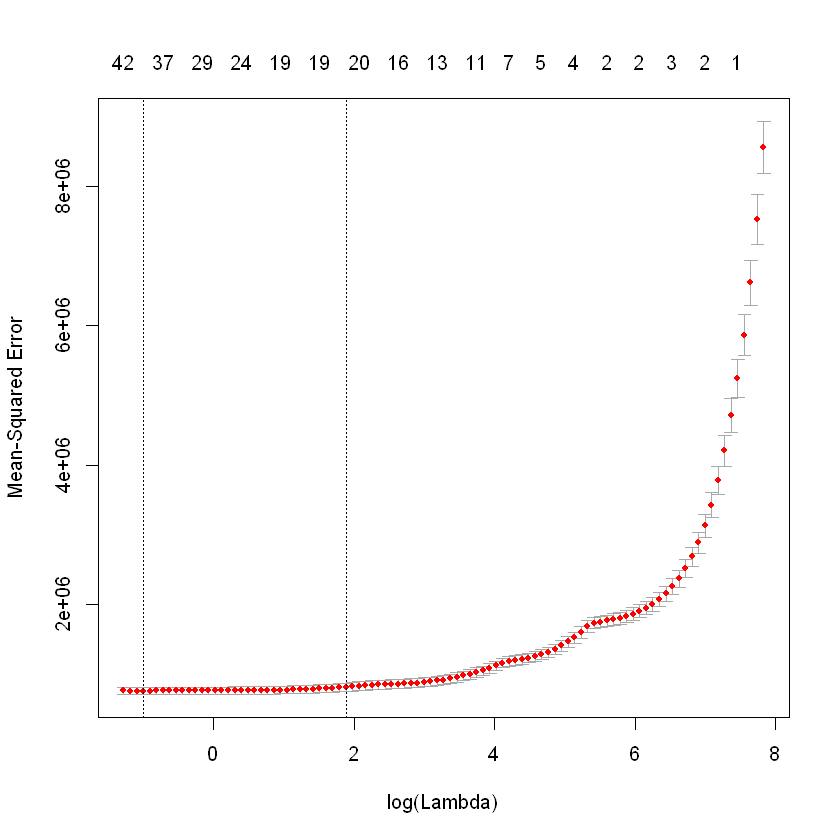

In [41]:
plot(cvfitd1[[2]])

In [42]:
cvfitd1[[2]]

$lambda
 [1] 2532.7118582 2307.7127174 2102.7018801 1915.9036405 1745.7000417
 [6] 1590.6168615 1449.3108436 1320.5580628 1203.2433242 1096.3505037
[11]  998.9537467  910.2094491  829.3489504  755.6718755  688.5400688
[16]  627.3720669  571.6380616  520.8553118  474.5839614  432.4232304
[21]  394.0079424  359.0053628  327.1123158  298.0525593  271.5743914
[26]  247.4484710  225.4658308  205.4360679  187.1856938  170.5566327
[31]  155.4048515  141.5991128  129.0198379  117.5580711  107.1145361
[36]   97.5987759   88.9283697   81.0282184   73.8298948   67.2710505
[41]   61.2948758   55.8496079   50.8880827   46.3673257   42.2481803
[46]   38.4949684   35.0751815   31.9591990   29.1200319   26.5330885
[51]   24.1759621   22.0282362   20.0713084   18.2882287   16.6635529
[56]   15.1832088   13.8343743   12.6053667   11.4855406   10.4651969
[61]    9.5354976    8.6883903    7.9165376    7.2132543    6.5724486
[66]    5.9885704    5.4565623    4.9718164    4.5301339    4.1276893
[71]    3.76

In [43]:
cvfitd1[[2]]$lambda.min

[1] 0.3674531

In [44]:
lambdas <- numeric()
for (h in seq(0,23)){
    lambdas <- c(lambdas,cvfitd1[[h+1]]$lambda.min)
}
lambdas

[1] 2.4545690 0.3674531 0.3820154 0.5314644 1.4284414 0.4820617 0.7584499
 [8] 1.3419621 0.5872530 0.9440436 2.5495183 1.3075080 0.9048093 1.8967146
[15] 2.2086383 0.3782535 0.3767563 0.3636840 0.3219363 0.2814082 0.2855782
[22] 0.3701676 0.5053412 0.3766110

## Predicting Values

In [45]:
dfDtest <- dtsplitD(dfD)[[2]]
dfDtest <- dfDtest[complete.cases(dfDtest)]

In [46]:
md1 <- list()
pd1 <- list()
MAPEd <- list()
for (h in seq(0,23)){
    filter = paste("H",h,sep="")
    testdata = dfDtest[Hour == (filter)]
    x = as.matrix(testdata[,-c('Consumption','Date','Hour'),with = FALSE])
    pd1[[h+1]] <- predict(cvfitd1[[h+1]], x, s = "lambda.min")
    MAPEd[[h+1]] = 100*abs(pd1[[h+1]]/testdata$Consumption-1)

}

In [47]:
MAPEd <- data.frame(MAPEd)
colnames(MAPEd) <- paste("MAPE_",unique(dfDtest$Hour),sep="")

## Performances of All 24 Models

In [48]:
summary(MAPEd)

    MAPE_H0          MAPE_H1           MAPE_H2           MAPE_H3       
 Min.   :0.0919   Min.   :0.05076   Min.   :0.01505   Min.   :0.04709  
 1st Qu.:0.4674   1st Qu.:0.46477   1st Qu.:0.42184   1st Qu.:0.46337  
 Median :1.0209   Median :1.28915   Median :1.21914   Median :1.34107  
 Mean   :1.3997   Mean   :1.54018   Mean   :1.49359   Mean   :1.38427  
 3rd Qu.:2.1428   3rd Qu.:2.37590   3rd Qu.:2.17982   3rd Qu.:1.82496  
 Max.   :4.2358   Max.   :3.92005   Max.   :6.18140   Max.   :4.14850  
    MAPE_H4           MAPE_H5          MAPE_H6          MAPE_H7       
 Min.   :0.02064   Min.   :0.1368   Min.   :0.1638   Min.   :0.09797  
 1st Qu.:0.68313   1st Qu.:0.7835   1st Qu.:0.7326   1st Qu.:0.57275  
 Median :1.26762   Median :1.3091   Median :1.5065   Median :1.54268  
 Mean   :1.38887   Mean   :1.4245   Mean   :1.6704   Mean   :1.81303  
 3rd Qu.:1.83431   3rd Qu.:1.7315   3rd Qu.:2.3501   3rd Qu.:2.23345  
 Max.   :3.81530   Max.   :4.3105   Max.   :5.0678   Max.   :5.88255  

We see a similar pattern among error statistics of seperate models of this approach to the one in Part c. All mean and median values of **H0-H7** interval are smaller than **2**. From **H8** to **H15** they are mostly between **3** and **4**. From **H16** to the end, we have again better results which are mostly smaller than **0** again.  
Outcomes of these models also indicate that they are more robust. We can promote this idea looking at differences between mean and median values and maximum error percentages. All maximum error percentages yield values smaller than **13%** most of them being under **10%**. 

## MAPE's of All Approachs

In [49]:
MAPEdAll <- reshape2::melt(MAPEd)["value"]
colnames(MAPEdAll)[1] <- "MAPEdAll" 

No id variables; using all as measure variables


In [50]:
summary(cbind(pAtest[,c("MAPE48","MAPE168")],MAPEb,MAPEcAll,MAPEdAll))

     MAPE48            MAPE168              MAPEb              MAPEcAll       
 Min.   : 0.00955   Min.   : 0.008521   Min.   : 0.000671   Min.   : 0.06864  
 1st Qu.: 1.64348   1st Qu.: 1.335853   1st Qu.: 1.824296   1st Qu.: 2.17941  
 Median : 5.72972   Median : 2.514032   Median : 3.310063   Median : 3.72969  
 Mean   : 8.06031   Mean   : 3.449188   Mean   : 4.228027   Mean   : 4.35771  
 3rd Qu.:10.10699   3rd Qu.: 4.548818   3rd Qu.: 5.706493   3rd Qu.: 5.91587  
 Max.   :43.77075   Max.   :19.565225   Max.   :16.605386   Max.   :16.57037  
    MAPEdAll        
 Min.   : 0.001939  
 1st Qu.: 0.765615  
 Median : 1.627420  
 Mean   : 2.452410  
 3rd Qu.: 3.160086  
 Max.   :12.915315  

Overall performance of Part d approach also seem to be much better compared to older models. Mean and median values are **1.63** and **2.45** respectively which are significantly smaller than closest values which are **2.51** and **3.45**. All error metrics of this approach is also far better than the other ones except minimum error percentage. 

# Part e

In [51]:
# install.packages("CVXR")
# .libPaths()

In [52]:
require("CVXR",quietly=TRUE)

Warning message:
"package 'CVXR' was built under R version 3.6.3"
Attaching package: 'CVXR'

The following object is masked from 'package:tseries':

    value

The following object is masked from 'package:stats':

    power



In [53]:
kfoldsplit <- function(data,k,order){
    order <- (order-1) %% k + 1
    n <- dim(data)[1]
    size <- ceiling(n/k)
    idx <- ((order-1)*size + 1):(min(order*size,n))
    
    train <- data[-idx]
    valid <- data[idx]
    res <- list()
    res[[1]] <- train
    res[[2]] <- valid
    return(res)
}

In [79]:
fusedloss <- function(X,y,beta,lambda1,lambda2){
    y = matrix(y,ncol = 1)
    X = matrix(X,ncol = dim(X)[2])
    loss = 0
    for (i in 1:dim(x)[1] ){
        yone = as.matrix(y[i],ncol = 1)
        xone = as.matrix(X[i,],nrow = 1)
        loss = loss + sum( (yone- t(xone) %*% beta)^2 )
    }
    loss = loss 
    lambda2 * sum( abs(beta) ) +
    lambda1 * sum( abs( (beta[ 3:25]-beta[ 2:24]) ) ) +
    lambda1 * sum( abs( (beta[27:49]-beta[26:48]) ) )
    return(loss)
}

In [80]:
kfoldloss <- function(data,k,lambda1,lambda2){
    loss = 0
    for(i in 1:k){
        train = as.data.table(kfoldsplit(data,k,i)[[1]])
        valid = as.data.table(kfoldsplit(data,k,i)[[2]])
        Xtr = train[,-c('Consumption','Date','Hour'),with = FALSE]
        Xtr = as.matrix(cbind(1,Xtr))
        Xtr = matrix(Xtr,ncol = dim(Xtr)[2])
        ytr = train$Consumption
        Xvalid = valid[,-c('Consumption','Date','Hour'),with = FALSE]
        Xvalid = as.matrix(cbind(1,Xvalid))
        Xvalid = matrix(Xvalid,ncol = dim(Xvalid)[2])
        yvalid = valid$Consumption
        
        beta <- Variable(49)
        obj <- Minimize(fusedloss(Xtr,ytr,beta,lambda1,lambda2))
        problem <- Problem(obj)
        sln <- solve(problem)
        betahat <- sln$getValue(beta)
        validloss =  sum( (yvalid - Xvalid %*% betahat)^2 )
        loss = loss + validloss
    }
    return(loss/k)
}

In [73]:
kfoldloss(dfDtrain[Hour == "H4"],10,5,5)

[1] 2241197821

In [ ]:
# Cannot optimize due to convexity limitations
sq <- seq(0,1,0.1)
res <- list()
for (h in seq(0,23)){
    dataf <- data.frame()
    for (l1 in sq){
        for (l2 in sq){
            filter = paste("H",h,sep="")
            data = dfDtrain[Hour == (filter)]
            l1 <- Variable(1)
            l2 <- Variable(1)
            dataf[paste(l1),paste(l2)] = kfoldloss(data,10,l1,l2)
        }
    }
    res[[h+1]] <- dataf
}

In [68]:
Xtest = dfDtest[,-c('Consumption','Date','Hour'),with = FALSE]
Xtest = as.matrix(cbind(1,Xtest))
Xtest = matrix(Xtest,ncol = dim(Xtest)[2])
ytest = dfDtest$Consumption
ytest = as.matrix(ytest,ncol=1)
MAPEe = 100*abs((Xtest %*% betahat)/ytest -1)
summary(MAPEe)

       V1          
 Min.   : 0.07069  
 1st Qu.: 4.00927  
 Median : 9.03111  
 Mean   :12.66948  
 3rd Qu.:21.89846  
 Max.   :41.39439  

# Part f

In [202]:
data = cbind(pAtest[,c("MAPE48","MAPE168")],MAPEb,MAPEcAll,MAPEdAll)

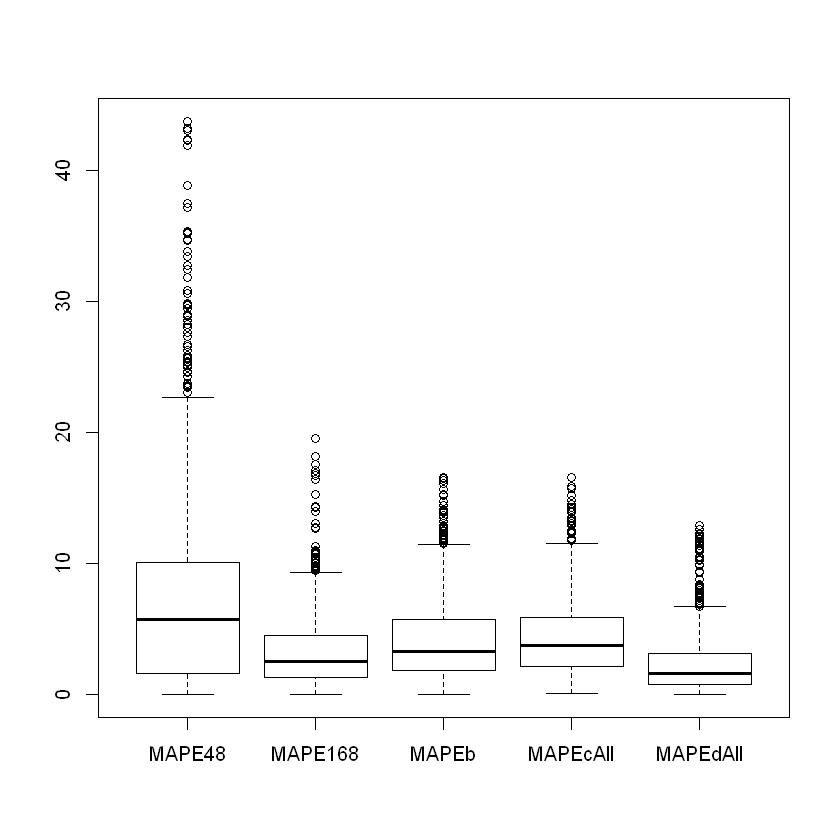

In [207]:
boxplot(data)

First, dispersion of naïve approaches are higher than other approaches as expected. However, MAPE of **Lag168** still looks competitive compared to other models and it even came out to be smaller than linear models of **Part b** and **Part c**. Considering **Lag168** as a baseline model, **Part d** model is the only satisfactory model we have. The dispersion of **Part d** also looks better than all other models. We can group approaches as **Part d** being the best; **Part c**, **Part b** and **Lag168** being in the middle ground and **Lag 48** being the worst.